In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cmocean
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable, Blues
import meanderpy as mp

def run_meander_simulation(freq_multiplier: float,
                           amplitude: float,
                           *,
                           n_perturb: int = 0,
                           perturb_magnitude: float = 0.0,
                           nit: int = 501,
                           saved_ts: int = 1,
                           random_seed: int | None = None):
    W = 50.0
    D = 1.0
    depths  = D * np.ones(nit)
    pad, deltas = 0, 50.0
    Cfs     = 0.0065 * np.ones(nit)
    crdist  = 5 * W
    kl      = 500.0 / (365*24*60*60.0)
    kv      = 1.0e-12
    dt      = 0.2 * 0.5 * 365*24*60*60.0
    dens    = 1000
    Sl      = 0.0
    t1 = t2 = t3 = 0
    aggr_factor = 0

    x_initial = np.linspace(0.1, 10_000, 1500)
    y_initial = (amplitude * 100.0) * np.sin(freq_multiplier * np.pi * x_initial / 10_000.0)

    if n_perturb and perturb_magnitude:
        idx = len(x_initial) // 2
        y_initial[idx] += perturb_magnitude

    z_initial = np.zeros_like(x_initial)
    ch  = mp.Channel(x_initial, y_initial, z_initial, W, depths[0])
    chb = mp.ChannelBelt([ch], [], [0.0], [])
    chb.migrate(nit, saved_ts, deltas, pad, crdist,
                depths, Cfs, kl, kv, dt, dens,
                t1, t2, t3, aggr_factor)
    return chb

def rasterize_channel(x, y, rows, cols, extent, n_seg=1000):
    x_min, x_max, y_min, y_max = extent
    dx = (x_max - x_min) / cols
    dy = (y_max - y_min) / rows
    canvas = np.zeros((rows, cols), dtype=np.int8)
    for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:]):
        xs = np.linspace(x0, x1, n_seg)
        ys = np.linspace(y0, y1, n_seg)
        c = ((xs - x_min) / dx).astype(int)
        r = ((ys - y_min) / dy).astype(int)
        m = (0 <= c) & (c < cols) & (0 <= r) & (r < rows)
        canvas[r[m], c[m]] = 1
    return canvas

def compute_log_norms_for_perturbations(chb_ref, perturbed_runs, perturbation_magnitudes, extent, grid_rows=500, grid_cols=1000, n_seg_rasterize=10):
    timesteps = len(chb_ref.channels)
    log_norms = {}

    for i, dY in enumerate(perturbation_magnitudes):
        chb_pert = perturbed_runs[i]
        all_norms = np.full((timesteps,), np.nan)

        for t in range(timesteps):
            ch0 = chb_ref.channels[t]
            ch1 = chb_pert.channels[t]
            if ch0 is None or ch1 is None: continue
            x0, y0 = getattr(ch0, 'x', None), getattr(ch0, 'y', None)
            x1, y1 = getattr(ch1, 'x', None), getattr(ch1, 'y', None)
            if any(v is None for v in (x0, y0, x1, y1)) or len(x0) < 2 or len(x1) < 2: continue
            try:
                g0 = rasterize_channel(x0, y0, grid_rows, grid_cols, extent, n_seg_rasterize)
                g1 = rasterize_channel(x1, y1, grid_rows, grid_cols, extent, n_seg_rasterize)
            except Exception: continue

            grid_diff = g1 - g0
            norm = np.linalg.norm(grid_diff)
            all_norms[t] = max(norm, 0.0)

        avg_norm = all_norms
        valid_indices = ~np.isnan(avg_norm)
        log_norm = np.full_like(avg_norm, np.nan)
        if np.any(valid_indices):
            valid_norms = avg_norm[valid_indices]
            valid_norms[valid_norms < 1e-15] = 1e-15
            log_norm[valid_indices] = np.log(valid_norms)

        log_norms[dY] = log_norm
    return log_norms

freq, A = 30.0, 3.0
extent = (0, 10_000, -2500, 2500)
grid_rows, grid_cols = 500, 1000
timesteps = 501

perturbation_magnitudes = [10**(-i) for i in range(1, 11)]

chb_ref = run_meander_simulation(freq, A)

perturbed_runs = [
    run_meander_simulation(freq, A, n_perturb=1, perturb_magnitude=dY, random_seed=i)
    for i, dY in enumerate(perturbation_magnitudes)
]

log_norms = compute_log_norms_for_perturbations(
    chb_ref=chb_ref,
    perturbed_runs=perturbed_runs,
    perturbation_magnitudes=perturbation_magnitudes,
    extent=extent,
    grid_rows=grid_rows,
    grid_cols=grid_cols,
    n_seg_rasterize=100
)

100%|██████████| 501/501 [00:02<00:00, 167.99it/s]


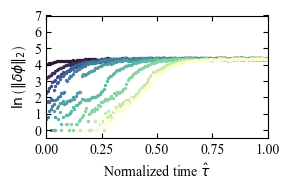

In [2]:
def plot_log_norms_perturbation(log_norms, saved_ts):
    plt.rcParams["font.family"] = "Times New Roman"
    fig, ax = plt.subplots(figsize=(3, 2))
    cmap = cmocean.cm.deep
    norm = LogNorm(vmin=min(log_norms.keys()), vmax=max(log_norms.keys()))
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    for dY, y in log_norms.items():
        color = cmap(norm(dY))
        x = np.arange(len(y)) 
        mask = (x >= 50) & (x <= 200) & (y >= 0)
        x_norm = (x[mask] - 50) / 150
        ax.scatter(x_norm, y[mask], color=color, s=2, label=f"{dY:.0e}")

    ax.set_xlabel(r'Normalized time $\hat{\tau}$')
    ax.set_ylabel(r'$\ln\left(\|\delta\phi\|_2\right)$')
    ax.set_xlim([0, 1])
    ax.set_ylim([-0.5, 7])
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
    ax.tick_params(axis='both', direction='in', top=True, right=True)

    plt.tight_layout()
    plt.show()

plot_log_norms_perturbation(log_norms, saved_ts=1)

Perturbation dY=1e-01: slope = 0.8090
Perturbation dY=1e-02: slope = 3.0791
Perturbation dY=1e-03: slope = 5.0431
Perturbation dY=1e-04: slope = 7.1197
Perturbation dY=1e-05: slope = 10.3528
Perturbation dY=1e-06: slope = 11.4962
Perturbation dY=1e-07: slope = 11.2991
Perturbation dY=1e-08: slope = 10.5987
Perturbation dY=1e-09: slope = 11.5469
Perturbation dY=1e-10: slope = 10.9433


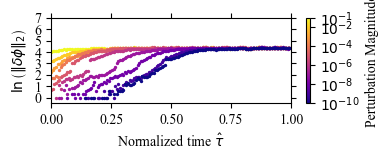

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import plasma
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import ScalarMappable

def plot_log_norms_and_slopes(log_norms, saved_ts=1):
    plt.rcParams["font.family"] = "Times New Roman"
    fig, ax = plt.subplots(figsize=(4, 1.7))

    perturbation_mags = sorted(log_norms.keys(), reverse=True)

    cmap = plasma
    norm = LogNorm(vmin=min(perturbation_mags), vmax=max(perturbation_mags))
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    for dY in perturbation_mags:
        color = cmap(norm(dY))
        y = np.array(log_norms[dY])
        x = np.arange(len(y)) * saved_ts

        mask = (x >= 50) & (x <= 200) & (y >= 0)
        x_masked = x[mask]
        y_masked = y[mask]
        if len(x_masked) < 5:
            print(f"dY={dY:.0e}: not enough points to fit.")
            continue

        x_norm = (x_masked - 50) / 150

        ax.scatter(x_norm, y_masked, color=color, s=2, label=f"{dY:.0e}")

        n_fit = min(50, len(x_norm))
        x_fit = x_norm[:n_fit]
        y_fit = y_masked[:n_fit]
        A = np.vstack([x_fit, np.ones_like(x_fit)]).T
        m, b = np.linalg.lstsq(A, y_fit, rcond=None)[0]
        print(f"Perturbation dY={dY:.0e}: slope = {m:.4f}")

    ax.set_xlabel(r'Normalized time $\hat{\tau}$')
    ax.set_ylabel(r'$\ln\left(\|\delta\phi\|_2\right)$')
    ax.set_xlim([0, 1])
    ax.set_ylim([-0.5, 7])
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
    ax.tick_params(axis='both', direction='out', top=True, right=True)

    cbar = fig.colorbar(sm, ax=ax, pad=0.05, ticks=[1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e-1])
    cbar.set_label("Perturbation Magnitude")
    cbar.ax.set_yticklabels([f"$10^{{{int(np.log10(v))}}}$" for v in [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e-1]])

    plt.tight_layout()
    plt.show()

plot_log_norms_and_slopes(log_norms, saved_ts=1)

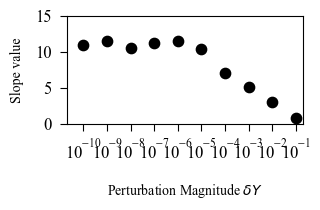

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogFormatterMathtext, FixedLocator

perturbations = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
slopes = [0.8090, 3.0791, 5.0431, 7.1197, 10.3528, 11.4962, 11.2991, 10.5987, 11.5469, 10.9433]

plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(3.3, 2.2))

ax.scatter(perturbations, slopes, color='k', s=55, zorder=2)

ax.set_xscale('log')
ax.set_xlim(2e-11, 2e-1)
ax.set_ylim(0, 15)

ax.xaxis.set_major_locator(FixedLocator(perturbations))
ax.xaxis.set_major_formatter(LogFormatterMathtext())

ax.set_xlabel(r'Perturbation Magnitude $\delta Y$', labelpad=14)
ax.set_ylabel("Slope value", labelpad=8)
ax.tick_params(axis='x', labelsize=12, pad=6, length=5)
ax.tick_params(axis='y', labelsize=12, pad=6, length=5)

plt.tight_layout()
plt.show()

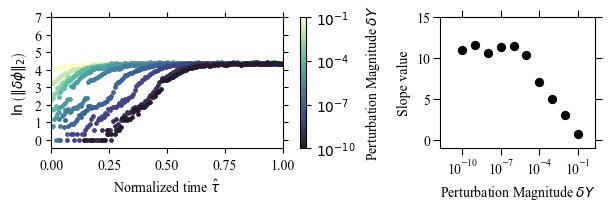

In [9]:
plt.rcParams["font.family"] = "Times New Roman"
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(6, 2),
    gridspec_kw={'width_ratios': [1.5, 1], 'wspace': 0.05},
    constrained_layout=True
)
saved_ts = 1

cmap = cmocean.cm.deep_r
norm = LogNorm(vmin=min(perturbations), vmax=max(perturbations))
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for dY in perturbations:
    color = cmap(norm(dY))
    y = np.array(log_norms[dY])
    x = np.arange(len(y)) * saved_ts
    mask = (x >= 50) & (x <= 200) & (y >= 0)
    x_norm = (x[mask] - 50) / 150
    y = y[mask]
    ax1.scatter(x_norm, y, color=color, s=6)

ax1.set_xlabel(r'Normalized time $\hat{\tau}$')
ax1.set_ylabel(r'$\ln\left(\|\delta\phi\|_2\right)$')
ax1.set_xlim([0, 1])
ax1.set_ylim([-0.5, 7])
ax1.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax1.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
ax1.tick_params(axis='both', direction='out', top=True, right=True)

cb_ticks = [1e-1, 1e-4, 1e-7, 1e-10]
cbar = fig.colorbar(sm, ax=ax1, pad=0.02) 
cbar.set_label(r'Perturbation Magnitude $\delta Y$', labelpad=6)
cbar.set_ticks(cb_ticks)
cbar.ax.set_yticklabels([fr"$10^{{{int(np.log10(tick))}}}$" for tick in cb_ticks])


ax2.scatter(perturbations, slopes, color='k', s=32, zorder=2)

ax2.set_xscale('log')
ax2.set_xlim(2e-12, 2e0)
ax2.set_ylim(-1, 15)
ax2.xaxis.set_major_locator(FixedLocator(perturbations[::3]))
ax2.xaxis.set_major_formatter(LogFormatterMathtext())

ax2.set_xlabel(r'Perturbation Magnitude $\delta Y$')
ax2.set_ylabel("Slope value")
ax2.tick_params(axis='both', direction='out', top=True, right=True, pad=2, length=5)

plt.show()